In [1]:
!pip install tensorflow

In [2]:
!pip install scikit-plot

In [3]:
import math
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import nltk
# import spacy
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from tqdm import tqdm

In [4]:
# calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += (row1[i] - row2[i])**2
    return math.sqrt(distance)

In [5]:
# Initialize the data to use

neg_data = open("all_neg.txt", "r", encoding='utf-8')
neg_lines = neg_data.readlines()
print (len(neg_lines))
neg_data.close()

pos_data = open("all_pos.txt", "r", encoding='utf-8')
pos_lines = pos_data.readlines()
print (len(pos_lines))
pos_data.close()

X_train = neg_lines[:250] + pos_lines[:250]
print(len(X_train))

neg_labels = [0 for i in range(250)]
pos_labels = [1 for i in range(250)]

X_labels = neg_labels + pos_labels

12500
12500
500


In [6]:
test_neg_data = open("test_neg.txt", "r", encoding='utf-8')
test_neg_lines = test_neg_data.readlines()
print (len(test_neg_lines))
test_neg_data.close()

test_pos_data = open("test_pos.txt", "r", encoding='utf-8')
test_pos_lines = test_pos_data.readlines()
print (len(test_pos_lines))
test_pos_data.close()

y_labels = neg_labels + pos_labels

12500
12500


In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from nltk.corpus import stopwords

# stops = set(stopwords.words('english'))
cv = CountVectorizer()
tfidfv = TfidfVectorizer()

# X_train_vectorized = []
# for i in range(10):
#   batch_vectorized = tfidfv.fit_transform(X_train[2500*i:2500*(i+1)]).toarray()
#   X_train_vectorized = X_train_vectorized + batch_vectorized

# print(len(X_train_vectorized))
sc = StandardScaler()
norm = Normalizer()
# X_train_vectorized = cv.fit_transform(X_train[:200]).toarray()

X_train_vectorized = norm.fit_transform(cv.fit_transform(X_train[:500]).toarray())
X_train_vectorized_labels = np.ndarray(shape=(500,X_train_vectorized[0].shape[0] + 1))
for i in range(len(X_train_vectorized)):
  X_train_vectorized_labels[i] = np.append(X_train_vectorized[i], X_labels[i])
print(X_train_vectorized_labels[-1])



[0. 0. 0. ... 0. 0. 1.]


In [8]:

# Locate the best matching unit
def get_best_matching_unit(codebooks, test_row):
	distances = list()
	for codebook in codebooks:
		dist = euclidean_distance(codebook, test_row)
		distances.append((codebook, dist))
	distances.sort(key=lambda tup: tup[1])
	return distances[0][0]

  # testing the bmu for row0
# test_row = row0
# bmu = get_best_matching_unit(X_train_vectorized, test_row)
# print(bmu)

In [9]:
from random import randrange
from sklearn.metrics import f1_score

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split


# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0


# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
  folds = cross_validation_split(dataset, n_folds)
  scores = list()
  for idx, fold in enumerate(folds):
    train_set = list(folds)
    train_set.pop(idx)
    train_set = sum(train_set, [])
    test_set = list()
    for row in fold:
      row_copy = list(row)
      test_set.append(row_copy)
      # print(row[-1])
      row_copy[-1] = None
    predicted = algorithm(train_set, test_set, *args)
    actual = [int(row[-1]) for row in fold]
    skplt.metrics.plot_confusion_matrix(actual, predicted)
    f1 = f1_score(actual, predicted, average='macro')
    accuracy = accuracy_metric(actual, predicted)
    scores.append(f1)
  return scores

# Make a prediction with codebook vectors
def predict(codebooks, test_row):
	bmu = get_best_matching_unit(codebooks, test_row)
	return int(bmu[-1])
 
# Create a random codebook vector
def random_codebook(train):
	n_records = len(train)
	n_features = len(train[0])
	codebook = [train[randrange(n_records)][i] for i in range(n_features)]
	return codebook
 
# Train a set of codebook vectors
def train_codebooks(train, n_codebooks, lrate, epochs):
  codebooks = [random_codebook(train) for i in range(n_codebooks)]
  for epoch in range(epochs):
    rate = lrate * (1.0-(epoch/float(epochs)))
    sum_error = 0.0
    for row in train:
      bmu = get_best_matching_unit(codebooks, row)
      for i in range(len(row)-1):
        error = row[i] - bmu[i]
        sum_error += error**2
        if bmu[-1] == row[-1]:
          bmu[i] += rate * error
        else:
          bmu[i] -= rate * error
    print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, rate, sum_error))
  return codebooks

# LVQ Algorithm
def learning_vector_quantization(train, test, n_codebooks, lrate, epochs):
  codebooks = train_codebooks(train, n_codebooks, lrate, epochs)
  predictions = list()
  for row in test:
    output = predict(codebooks, row)
    predictions.append(output)
  return(predictions)

In [20]:
epochs = 10
lr = 0.3
n_codebooks = 20
n_folds = 4

>epoch=0, lrate=0.300, error=309.295
>epoch=1, lrate=0.270, error=364.310
>epoch=2, lrate=0.240, error=461.045
>epoch=3, lrate=0.210, error=494.934
>epoch=4, lrate=0.180, error=537.759
>epoch=5, lrate=0.150, error=499.141
>epoch=6, lrate=0.120, error=470.580
>epoch=7, lrate=0.090, error=394.821
>epoch=8, lrate=0.060, error=373.578
>epoch=9, lrate=0.030, error=287.522
>epoch=0, lrate=0.300, error=307.309
>epoch=1, lrate=0.270, error=372.896
>epoch=2, lrate=0.240, error=449.991
>epoch=3, lrate=0.210, error=501.815
>epoch=4, lrate=0.180, error=623.373
>epoch=5, lrate=0.150, error=619.042
>epoch=6, lrate=0.120, error=758.497
>epoch=7, lrate=0.090, error=819.152
>epoch=8, lrate=0.060, error=624.716
>epoch=9, lrate=0.030, error=456.199
>epoch=0, lrate=0.300, error=306.864
>epoch=1, lrate=0.270, error=360.486
>epoch=2, lrate=0.240, error=423.928
>epoch=3, lrate=0.210, error=472.651
>epoch=4, lrate=0.180, error=557.331
>epoch=5, lrate=0.150, error=625.464
>epoch=6, lrate=0.120, error=621.545
>

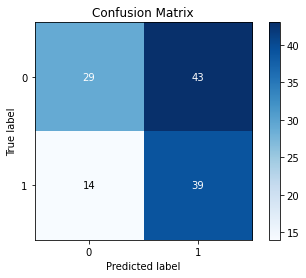

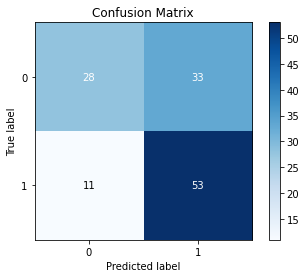

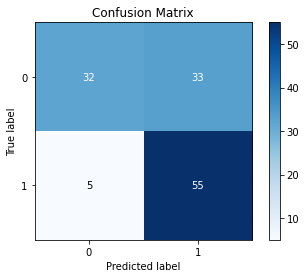

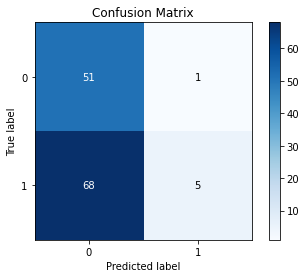

In [21]:
scores = evaluate_algorithm(X_train_vectorized_labels, learning_vector_quantization, n_folds, n_codebooks, lr, epochs)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

>epoch=0, lrate=0.300, error=447.330
>epoch=1, lrate=0.285, error=701.855
>epoch=2, lrate=0.270, error=1019.225
>epoch=3, lrate=0.255, error=1646.028
>epoch=4, lrate=0.240, error=1404.930
>epoch=5, lrate=0.225, error=1652.021
>epoch=6, lrate=0.210, error=1631.811
>epoch=7, lrate=0.195, error=1674.984
>epoch=8, lrate=0.180, error=1656.727
>epoch=9, lrate=0.165, error=1651.655
>epoch=10, lrate=0.150, error=1632.164
>epoch=11, lrate=0.135, error=1594.390
>epoch=12, lrate=0.120, error=1547.150
>epoch=13, lrate=0.105, error=1504.790
>epoch=14, lrate=0.090, error=1505.166
>epoch=15, lrate=0.075, error=1561.925
>epoch=16, lrate=0.060, error=1695.223
>epoch=17, lrate=0.045, error=1926.000
>epoch=18, lrate=0.030, error=2263.095
>epoch=19, lrate=0.015, error=2660.734
>epoch=0, lrate=0.300, error=468.073
>epoch=1, lrate=0.285, error=740.595
>epoch=2, lrate=0.270, error=2310.911
>epoch=3, lrate=0.255, error=1326.559
>epoch=4, lrate=0.240, error=1607.558
>epoch=5, lrate=0.225, error=1487.275
>epoch

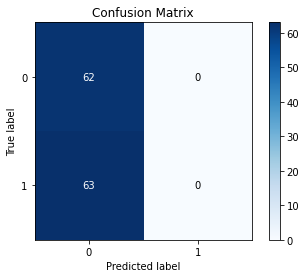

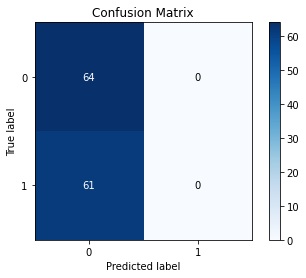

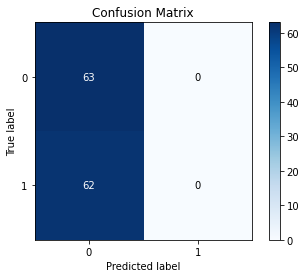

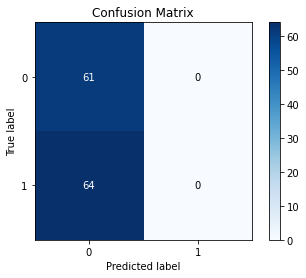

In [22]:
epochs2 = 20
lr2 = 0.3
n_codebooks2 = 10
n_folds2 = 4

scores = evaluate_algorithm(X_train_vectorized_labels, learning_vector_quantization, n_folds2, n_codebooks2, lr2, epochs2)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

>epoch=0, lrate=0.300, error=282.247
>epoch=1, lrate=0.280, error=319.724
>epoch=2, lrate=0.260, error=340.571
>epoch=3, lrate=0.240, error=328.852
>epoch=4, lrate=0.220, error=356.171
>epoch=5, lrate=0.200, error=388.365
>epoch=6, lrate=0.180, error=345.097
>epoch=7, lrate=0.160, error=371.878
>epoch=8, lrate=0.140, error=423.373
>epoch=9, lrate=0.120, error=406.823
>epoch=10, lrate=0.100, error=372.353
>epoch=11, lrate=0.080, error=385.436
>epoch=12, lrate=0.060, error=247.605
>epoch=13, lrate=0.040, error=189.201
>epoch=14, lrate=0.020, error=183.713
>epoch=0, lrate=0.300, error=275.030
>epoch=1, lrate=0.280, error=314.540
>epoch=2, lrate=0.260, error=338.314
>epoch=3, lrate=0.240, error=347.649
>epoch=4, lrate=0.220, error=356.269
>epoch=5, lrate=0.200, error=372.611
>epoch=6, lrate=0.180, error=319.635
>epoch=7, lrate=0.160, error=382.798
>epoch=8, lrate=0.140, error=360.384
>epoch=9, lrate=0.120, error=384.901
>epoch=10, lrate=0.100, error=294.595
>epoch=11, lrate=0.080, error=23

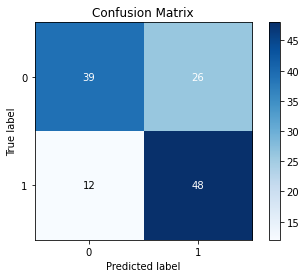

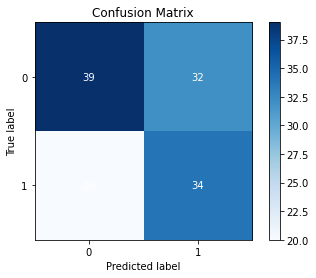

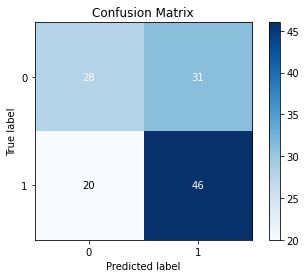

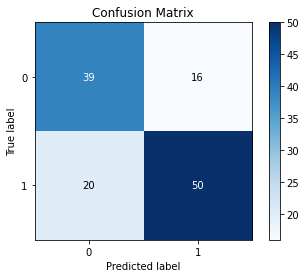

In [ ]:
epochs3 = 15
lr3 = 0.3
n_codebooks3 = 40
n_folds3 = 4

scores3 = evaluate_algorithm(X_train_vectorized_labels, learning_vector_quantization, n_folds3, n_codebooks3, lr3, epochs3)
print('Scores: %s' % scores3)
print('Mean Accuracy: %.3f%%' % (sum(scores3)/float(len(scores3))))

>epoch=0, lrate=0.300, error=262.869
>epoch=1, lrate=0.283, error=273.960
>epoch=2, lrate=0.267, error=271.720
>epoch=3, lrate=0.250, error=254.770
>epoch=4, lrate=0.233, error=249.889
>epoch=5, lrate=0.217, error=245.994
>epoch=6, lrate=0.200, error=229.152
>epoch=7, lrate=0.183, error=214.653
>epoch=8, lrate=0.167, error=202.857
>epoch=9, lrate=0.150, error=196.188
>epoch=10, lrate=0.133, error=193.491
>epoch=11, lrate=0.117, error=182.732
>epoch=12, lrate=0.100, error=178.322
>epoch=13, lrate=0.083, error=173.598
>epoch=14, lrate=0.067, error=166.482
>epoch=15, lrate=0.050, error=162.510
>epoch=16, lrate=0.033, error=159.604
>epoch=17, lrate=0.017, error=156.832
>epoch=0, lrate=0.300, error=274.586
>epoch=1, lrate=0.283, error=305.501
>epoch=2, lrate=0.267, error=299.623
>epoch=3, lrate=0.250, error=311.724
>epoch=4, lrate=0.233, error=317.898
>epoch=5, lrate=0.217, error=306.578
>epoch=6, lrate=0.200, error=337.382
>epoch=7, lrate=0.183, error=319.923
>epoch=8, lrate=0.167, error=2

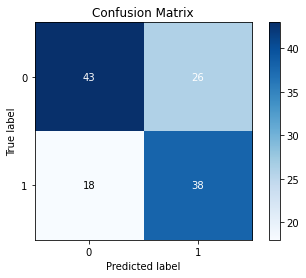

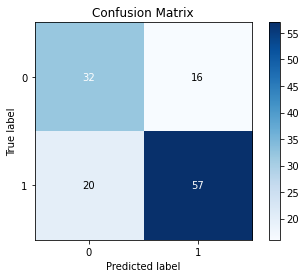

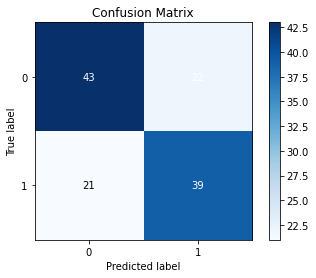

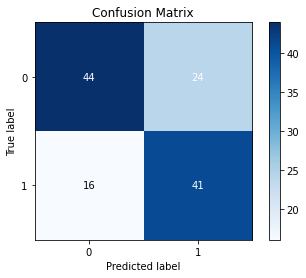

In [10]:
epochs4 = 18
lr4 = 0.3
n_codebooks4 = 50
n_folds4 = 4

scores4 = evaluate_algorithm(X_train_vectorized_labels, learning_vector_quantization, n_folds4, n_codebooks4, lr4, epochs4)
print('Scores: %s' % scores4)
print('Mean Accuracy: %.3f%%' % (sum(scores4)/float(len(scores4))))

>epoch=0, lrate=0.300, error=258.323
>epoch=1, lrate=0.275, error=255.225
>epoch=2, lrate=0.250, error=263.671
>epoch=3, lrate=0.225, error=252.340
>epoch=4, lrate=0.200, error=235.615
>epoch=5, lrate=0.175, error=217.777
>epoch=6, lrate=0.150, error=212.290
>epoch=7, lrate=0.125, error=199.143
>epoch=8, lrate=0.100, error=187.263
>epoch=9, lrate=0.075, error=178.061
>epoch=10, lrate=0.050, error=170.311
>epoch=11, lrate=0.025, error=164.582
>epoch=0, lrate=0.300, error=269.661
>epoch=1, lrate=0.275, error=269.439
>epoch=2, lrate=0.250, error=274.073
>epoch=3, lrate=0.225, error=269.023
>epoch=4, lrate=0.200, error=256.237
>epoch=5, lrate=0.175, error=248.110
>epoch=6, lrate=0.150, error=242.045
>epoch=7, lrate=0.125, error=215.792
>epoch=8, lrate=0.100, error=192.067
>epoch=9, lrate=0.075, error=183.590
>epoch=10, lrate=0.050, error=176.812
>epoch=11, lrate=0.025, error=169.259
>epoch=0, lrate=0.300, error=263.173
>epoch=1, lrate=0.275, error=266.882
>epoch=2, lrate=0.250, error=267.2

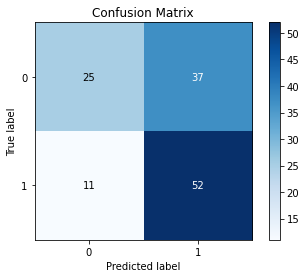

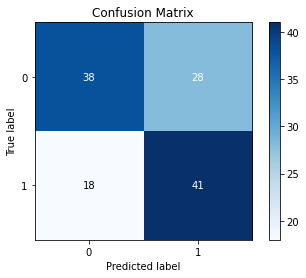

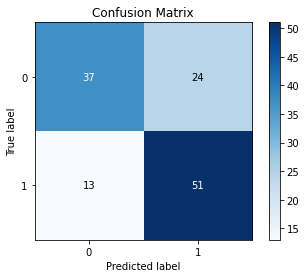

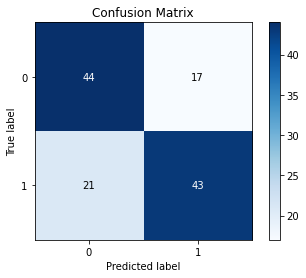

In [11]:
epochs5 = 12
lr5 = 0.3
n_codebooks5 = 80
n_folds5 = 4

scores5 = evaluate_algorithm(X_train_vectorized_labels, learning_vector_quantization, n_folds5, n_codebooks5, lr5, epochs5)
print('Scores: %s' % scores5)
print('Mean Accuracy: %.3f%%' % (sum(scores5)/float(len(scores5))))

>epoch=0, lrate=0.300, error=267.443
>epoch=1, lrate=0.285, error=271.273
>epoch=2, lrate=0.270, error=263.053
>epoch=3, lrate=0.255, error=248.909
>epoch=4, lrate=0.240, error=242.775
>epoch=5, lrate=0.225, error=234.420
>epoch=6, lrate=0.210, error=223.839
>epoch=7, lrate=0.195, error=212.454
>epoch=8, lrate=0.180, error=207.637
>epoch=9, lrate=0.165, error=203.795
>epoch=10, lrate=0.150, error=204.735
>epoch=11, lrate=0.135, error=195.407
>epoch=12, lrate=0.120, error=186.306
>epoch=13, lrate=0.105, error=180.629
>epoch=14, lrate=0.090, error=174.868
>epoch=15, lrate=0.075, error=171.708
>epoch=16, lrate=0.060, error=168.142
>epoch=17, lrate=0.045, error=165.787
>epoch=18, lrate=0.030, error=163.398
>epoch=19, lrate=0.015, error=161.220
>epoch=0, lrate=0.300, error=278.384
>epoch=1, lrate=0.285, error=263.827
>epoch=2, lrate=0.270, error=264.302
>epoch=3, lrate=0.255, error=244.482
>epoch=4, lrate=0.240, error=233.601
>epoch=5, lrate=0.225, error=224.533
>epoch=6, lrate=0.210, error

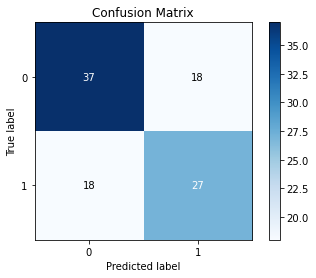

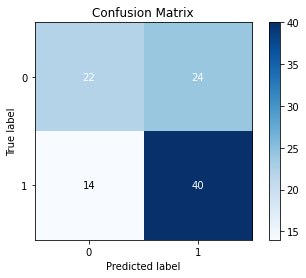

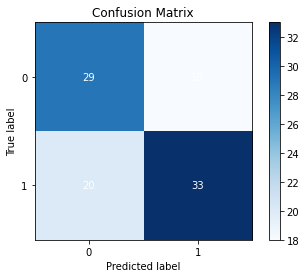

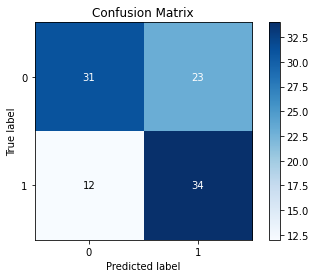

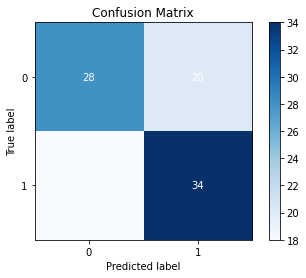

In [12]:
epochs6 = 20
lr6 = 0.3
n_codebooks6 = 120
n_folds6 = 5

scores6 = evaluate_algorithm(X_train_vectorized_labels, learning_vector_quantization, n_folds6, n_codebooks6, lr6, epochs6)
print('Scores: %s' % scores6)
print('Mean Accuracy: %.3f%%' % (sum(scores6)/float(len(scores6))))

>epoch=0, lrate=0.300, error=211.809
>epoch=1, lrate=0.280, error=197.092
>epoch=2, lrate=0.260, error=182.422
>epoch=3, lrate=0.240, error=177.956
>epoch=4, lrate=0.220, error=169.133
>epoch=5, lrate=0.200, error=157.099
>epoch=6, lrate=0.180, error=150.056
>epoch=7, lrate=0.160, error=144.431
>epoch=8, lrate=0.140, error=138.893
>epoch=9, lrate=0.120, error=134.260
>epoch=10, lrate=0.100, error=130.398
>epoch=11, lrate=0.080, error=127.262
>epoch=12, lrate=0.060, error=124.509
>epoch=13, lrate=0.040, error=122.274
>epoch=14, lrate=0.020, error=119.948
>epoch=0, lrate=0.300, error=213.133
>epoch=1, lrate=0.280, error=200.490
>epoch=2, lrate=0.260, error=192.637
>epoch=3, lrate=0.240, error=181.335
>epoch=4, lrate=0.220, error=172.811
>epoch=5, lrate=0.200, error=162.028
>epoch=6, lrate=0.180, error=152.128
>epoch=7, lrate=0.160, error=148.264
>epoch=8, lrate=0.140, error=143.070
>epoch=9, lrate=0.120, error=140.282
>epoch=10, lrate=0.100, error=135.518
>epoch=11, lrate=0.080, error=13

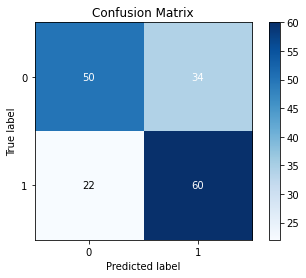

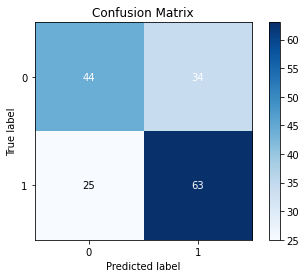

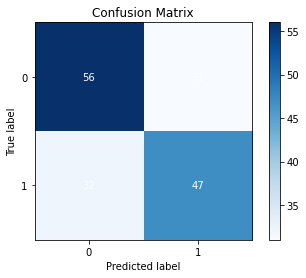

In [13]:
epochs7 = 15
lr7 = 0.3
n_codebooks7 = 250
n_folds7 = 3

scores7 = evaluate_algorithm(X_train_vectorized_labels, learning_vector_quantization, n_folds7, n_codebooks7, lr7, epochs7)
print('Scores: %s' % scores7)
print('Mean Accuracy: %.3f%%' % (sum(scores7)/float(len(scores7))))

>epoch=0, lrate=0.300, error=211.205
>epoch=1, lrate=0.280, error=201.022
>epoch=2, lrate=0.260, error=185.265
>epoch=3, lrate=0.240, error=171.350
>epoch=4, lrate=0.220, error=156.461
>epoch=5, lrate=0.200, error=148.239
>epoch=6, lrate=0.180, error=141.634
>epoch=7, lrate=0.160, error=134.481
>epoch=8, lrate=0.140, error=130.129
>epoch=9, lrate=0.120, error=127.211
>epoch=10, lrate=0.100, error=123.869
>epoch=11, lrate=0.080, error=121.058
>epoch=12, lrate=0.060, error=118.188
>epoch=13, lrate=0.040, error=115.547
>epoch=14, lrate=0.020, error=113.130
>epoch=0, lrate=0.300, error=210.134
>epoch=1, lrate=0.280, error=203.183
>epoch=2, lrate=0.260, error=190.233
>epoch=3, lrate=0.240, error=165.592
>epoch=4, lrate=0.220, error=156.475
>epoch=5, lrate=0.200, error=150.244
>epoch=6, lrate=0.180, error=144.221
>epoch=7, lrate=0.160, error=137.615
>epoch=8, lrate=0.140, error=133.128
>epoch=9, lrate=0.120, error=130.144
>epoch=10, lrate=0.100, error=126.647
>epoch=11, lrate=0.080, error=12

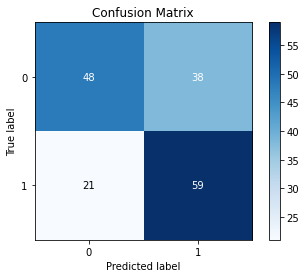

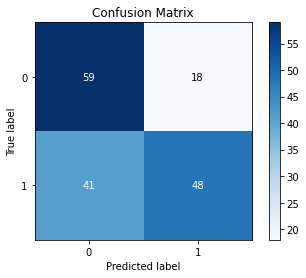

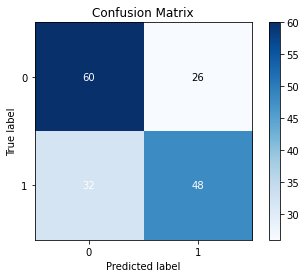

In [14]:
epochs8 = 15
lr8 = 0.3
n_codebooks8 = 400
n_folds8 = 3

scores8 = evaluate_algorithm(X_train_vectorized_labels, learning_vector_quantization, n_folds8, n_codebooks8, lr8, epochs8)
print('Scores: %s' % scores8)
print('Mean Accuracy: %.3f%%' % (sum(scores8)/float(len(scores8))))

>epoch=0, lrate=0.300, error=207.390
>epoch=1, lrate=0.280, error=192.694
>epoch=2, lrate=0.260, error=174.371
>epoch=3, lrate=0.240, error=161.516
>epoch=4, lrate=0.220, error=153.074
>epoch=5, lrate=0.200, error=142.589
>epoch=6, lrate=0.180, error=134.639
>epoch=7, lrate=0.160, error=129.383
>epoch=8, lrate=0.140, error=126.115
>epoch=9, lrate=0.120, error=121.322
>epoch=10, lrate=0.100, error=118.478
>epoch=11, lrate=0.080, error=115.990
>epoch=12, lrate=0.060, error=113.592
>epoch=13, lrate=0.040, error=111.384
>epoch=14, lrate=0.020, error=109.308
>epoch=0, lrate=0.300, error=202.695
>epoch=1, lrate=0.280, error=193.597
>epoch=2, lrate=0.260, error=179.776
>epoch=3, lrate=0.240, error=167.867
>epoch=4, lrate=0.220, error=160.607
>epoch=5, lrate=0.200, error=149.394
>epoch=6, lrate=0.180, error=145.230
>epoch=7, lrate=0.160, error=139.640
>epoch=8, lrate=0.140, error=135.187
>epoch=9, lrate=0.120, error=129.840
>epoch=10, lrate=0.100, error=125.919
>epoch=11, lrate=0.080, error=12

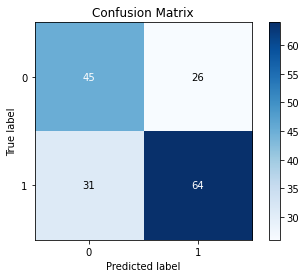

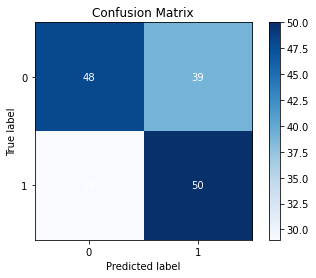

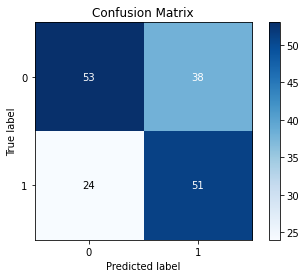

In [15]:
epochs9 = 15
lr9 = 0.3
n_codebooks9 = 600
n_folds9 = 3

scores9 = evaluate_algorithm(X_train_vectorized_labels, learning_vector_quantization, n_folds9, n_codebooks9, lr9, epochs9)
print('Scores: %s' % scores9)
print('Mean Accuracy: %.3f%%' % (sum(scores9)/float(len(scores9))))

>epoch=0, lrate=0.400, error=214.656
>epoch=1, lrate=0.373, error=195.167
>epoch=2, lrate=0.347, error=177.575
>epoch=3, lrate=0.320, error=169.533
>epoch=4, lrate=0.293, error=159.550
>epoch=5, lrate=0.267, error=151.502
>epoch=6, lrate=0.240, error=140.155
>epoch=7, lrate=0.213, error=133.766
>epoch=8, lrate=0.187, error=124.979
>epoch=9, lrate=0.160, error=117.771
>epoch=10, lrate=0.133, error=114.597
>epoch=11, lrate=0.107, error=110.678
>epoch=12, lrate=0.080, error=106.943
>epoch=13, lrate=0.053, error=103.951
>epoch=14, lrate=0.027, error=101.211
>epoch=0, lrate=0.400, error=208.761
>epoch=1, lrate=0.373, error=187.843
>epoch=2, lrate=0.347, error=173.945
>epoch=3, lrate=0.320, error=162.506
>epoch=4, lrate=0.293, error=154.841
>epoch=5, lrate=0.267, error=146.190
>epoch=6, lrate=0.240, error=141.219
>epoch=7, lrate=0.213, error=134.762
>epoch=8, lrate=0.187, error=129.509
>epoch=9, lrate=0.160, error=124.813
>epoch=10, lrate=0.133, error=119.064
>epoch=11, lrate=0.107, error=11

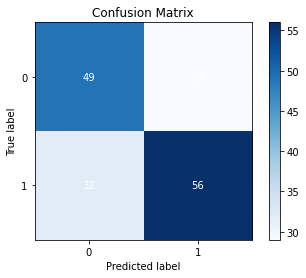

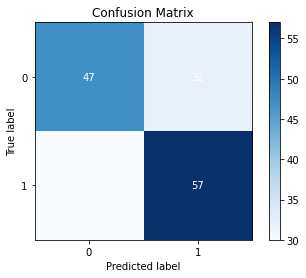

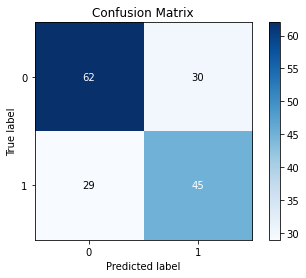

In [16]:
epochs10 = 15
lr10 = 0.4
n_codebooks10 = 600
n_folds10 = 3

scores10 = evaluate_algorithm(X_train_vectorized_labels, learning_vector_quantization, n_folds10, n_codebooks10, lr10, epochs10)
print('Scores: %s' % scores10)
print('Mean Accuracy: %.3f%%' % (sum(scores10)/float(len(scores10))))

>epoch=0, lrate=0.500, error=212.112
>epoch=1, lrate=0.467, error=192.421
>epoch=2, lrate=0.433, error=168.555
>epoch=3, lrate=0.400, error=158.563
>epoch=4, lrate=0.367, error=148.663
>epoch=5, lrate=0.333, error=135.859
>epoch=6, lrate=0.300, error=129.268
>epoch=7, lrate=0.267, error=121.811
>epoch=8, lrate=0.233, error=115.658
>epoch=9, lrate=0.200, error=107.882
>epoch=10, lrate=0.167, error=102.865
>epoch=11, lrate=0.133, error=98.870
>epoch=12, lrate=0.100, error=94.795
>epoch=13, lrate=0.067, error=91.575
>epoch=14, lrate=0.033, error=88.406
>epoch=0, lrate=0.500, error=216.715
>epoch=1, lrate=0.467, error=186.742
>epoch=2, lrate=0.433, error=162.825
>epoch=3, lrate=0.400, error=149.017
>epoch=4, lrate=0.367, error=140.935
>epoch=5, lrate=0.333, error=137.575
>epoch=6, lrate=0.300, error=132.253
>epoch=7, lrate=0.267, error=124.037
>epoch=8, lrate=0.233, error=116.192
>epoch=9, lrate=0.200, error=106.894
>epoch=10, lrate=0.167, error=101.193
>epoch=11, lrate=0.133, error=96.081

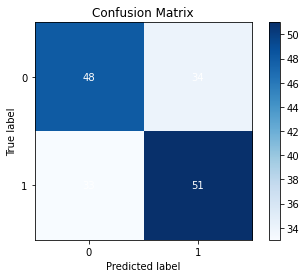

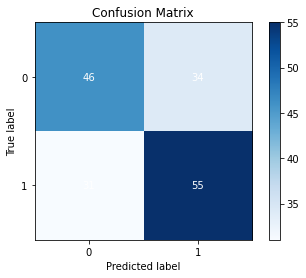

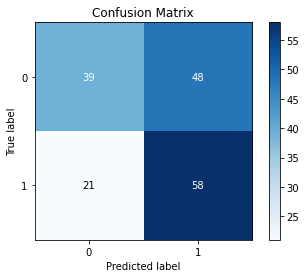

In [17]:
epochs11 = 15
lr11 = 0.5
n_codebooks11 = 600
n_folds11 = 3

scores11 = evaluate_algorithm(X_train_vectorized_labels, learning_vector_quantization, n_folds11, n_codebooks11, lr11, epochs11)
print('Scores: %s' % scores11)
print('Mean Accuracy: %.3f%%' % (sum(scores11)/float(len(scores11))))